# Conformal Prediction on Spotify Song Genres

### Author:  Yicong Li
### Date: 20231208

## Abstract

1. training a neural network on your data, including a plot of your loss vs. training iteration;
2. a prediction interval calculated using conformal inference, including a written explanation of the result;
3. a hypothesis test, including a written explanation of why you chose that specific hypothesis test, and an explanation of the results of the test.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
import itertools
import os 

# added to solve dead kernel issue of plotting example figures
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')
torch.cuda.is_available()

True

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Problem Formulation

### Objective

To better make decides on genre classification of songs.We woud like to predict the likelihood of a song's genre mainly based on its sound features, using Neural Network with Conformal Prediction.

## Data Acquisition and Integration

### Data source

The data comes from Kaggle.spotify_songs.csv contains Almost 30,000 Songs from the Spotify API. The download address is: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs/


### Data description

#### Key attributes
* genres in "playlist_genre"
* numerical feautres: "track_popularity", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
* unused features: 
    * "track_artist","track_album_id", "playlist_id" (feature overload)
    * "playlist_subgenre" (highly correlated to what we want to preidct) 
    * "track_album_release_date" (highly correlated to "track_album_id")
    * "track_id" (uniquie for every song)
    * "track_name", "track_album_name", "playlist_name" (function similarly as "track_id", "track_album_id", "playlist_id" respectively)

| variable | class | description |
| :- | :- | :- |
| track_id | character | Song unique ID |
| track_name | character | Song Name |
| track_artist | character | Song Artist |
| track_popularity | double | Song Popularity (0-100) where higher is better |
| track_album_id | character | Album unique ID |
| track_album_name | character | Song album name |
| track_album_release_date | character | Date when album released |
| playlist_name | character | Name of playlist |
| playlist_id | character | Playlist ID |
| playlist_genre | character | Playlist genre |
| playlist_subgenre | character | Playlist subgenre |
| danceability | double | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| energy | double | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| key | double | The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| loudness | double | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. |
| mode | double | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| speechiness | double | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| acousticness | double | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| instrumentalness | double | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| liveness | double | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| valence | double | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| tempo | double | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| duration_ms | double | Duration of song in milliseconds |

### Data Preprocess

In [3]:
# Load data
spotify_df = pd.read_csv('spotify_songs.csv')

In [4]:
# Shuffle the rows
songs_df = spotify_df.sample(frac=1, random_state=42).reset_index(drop=True)

#  Define the features relevant for genre prediction
num_features = ["track_popularity", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"]
cat_features = []

# Drop playlist_subgenre
songs_df.drop(["track_artist", "track_id", "track_album_id", "playlist_id", "track_name", "track_album_name", "playlist_name", "track_album_release_date", "playlist_subgenre"], axis=1, inplace = True)

songs_df["playlist_genre"].unique()  

array(['edm', 'rock', 'r&b', 'rap', 'latin', 'pop'], dtype=object)

In [5]:
# Get Dummies of the target column
songs_df = pd.get_dummies(songs_df, columns=cat_features+["playlist_genre"])
rename_dict = {
    'playlist_genre_edm': 'edm',
    'playlist_genre_latin': 'latin',
    'playlist_genre_pop': 'pop',
    'playlist_genre_r&b': 'r&b',
    'playlist_genre_rap': 'rap',
    'playlist_genre_rock': 'rock'
}
songs_df.rename(columns=rename_dict, inplace=True)

# Updated list of genres after renaming
playlist_genre = list(rename_dict.values())

# Print the first few rows of the selected features
print(songs_df.head())

   track_popularity  danceability  energy  key  loudness  mode  speechiness  \
0                45         0.520   0.789    0    -7.717     1       0.0432   
1                17         0.651   0.661    9   -11.405     1       0.0511   
2                30         0.640   0.758   10    -5.204     1       0.1600   
3                35         0.398   0.966    4    -2.352     0       0.0453   
4                62         0.447   0.625   10    -8.212     0       0.3230   

   acousticness  instrumentalness  liveness  valence    tempo  duration_ms  \
0      0.004910          0.000013    0.0816    0.415  174.026       216347   
1      0.265000          0.003130    0.1060    0.489  156.371       378707   
2      0.665000          0.000000    0.1270    0.932   86.529       218044   
3      0.000006          0.000000    0.3030    0.520   90.016       208196   
4      0.035100          0.000727    0.2430    0.261   67.104       440013   

   edm  latin  pop  r&b  rap  rock  
0    1      0    0 

In [6]:
# Normalization on predictors
x = songs_df[num_features]
songs_df[num_features] = (x - x.min())/(x.max() - x.min())
songs_df[num_features].head()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.45,0.528993,0.788963,0.000000,0.811579,1.0,0.047059,0.004940,0.000013,0.081928,0.418769,0.726804,0.413279
1,0.17,0.662258,0.660941,0.818182,0.734300,1.0,0.055664,0.266600,0.003149,0.106426,0.493441,0.653070,0.729272
2,0.30,0.651068,0.757958,0.909091,0.864237,1.0,0.174292,0.669014,0.000000,0.127510,0.940464,0.361381,0.416582
3,0.35,0.404883,0.965994,0.363636,0.923999,0.0,0.049346,0.000006,0.000000,0.304217,0.524723,0.375944,0.397415
4,0.62,0.454730,0.624934,0.909091,0.801207,0.0,0.351852,0.035312,0.000731,0.243976,0.263370,0.280254,0.848588


## Create data

In [7]:
x = np.array(songs_df.drop(playlist_genre, axis=1))
y = np.array(songs_df[playlist_genre])

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

## Split Data

Split data X, Y into training and test data.

Further split training data into D1 and D2, where D1 is used to train predictive model and D2 is used to calibrate prediction set.

In [8]:
ntrain = 25000
n1 = 20000

x_train = x[:ntrain]
x_test = x[ntrain:]

y_train = y[:ntrain]
y_test = y[ntrain:]

# split based on n1
x_train1 = x_train[:n1]
y_train1 = y_train[:n1]

x_train2 = x_train[n1:]
y_train2 = y_train[n1:]

## Neural Network

Create a feed-forward neural network to predict movie genres

In [9]:
class SongNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super(SongNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
def accuracy_fn(y_true, y_pred, threshold=0.5):
    # Apply a threshold to y_pred to convert probabilities to binary predictions
    y_pred_thresh = (y_pred > threshold).float()
    correct = torch.eq(y_true, y_pred_thresh).sum().item()
    total = y_true.numel()
    acc = (correct / total) * 100
    return acc

Train the neural network to predict movie genres

In [12]:
## train neural network to predict genres
train_loss = []
train_acc = []
train_data = TensorDataset(x_train1, y_train1)
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)

epochs = 200
hidden_dims = [32, 16]

# train the neural network with the given specifications.
model = SongNet(x.shape[1], hidden_dims, len(playlist_genre))

## send the model to the GPU if available
model = model.to(device)

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()  # set the model to training mode
    batch_loss = []
    batch_acc = []
    
    for x_batch, y_batch in train_loader:
        # Send data to the device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_pred = model(x_batch)
        acc = accuracy_fn(y_batch, y_pred)
        
        loss = F.binary_cross_entropy(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_loss.append(loss.item())
        batch_acc.append(acc)
        
    epoch_loss = np.mean(batch_loss)
    epoch_acc = np.mean(batch_acc)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {epoch_acc:.2f}%')

Epoch 0, Loss: 0.4330, Accuracy: 82.96%
Epoch 50, Loss: 0.3106, Accuracy: 85.71%
Epoch 100, Loss: 0.3791, Accuracy: 86.26%
Epoch 150, Loss: 0.3865, Accuracy: 86.47%


### Loss vs. Training iteration plot

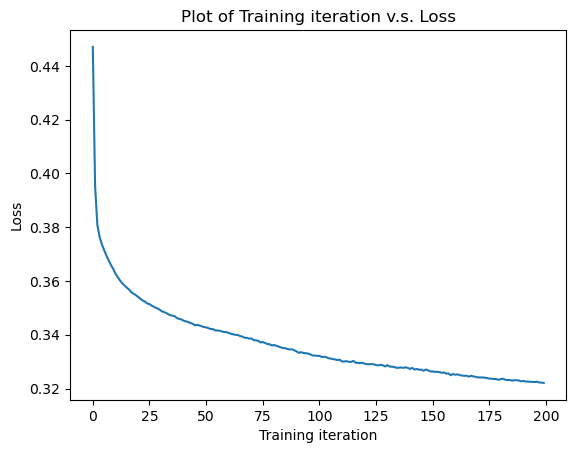

In [13]:
train_loss = [loss.item() for loss in train_loss]
plt.plot(train_loss)

# Adding title and labels (optional)
plt.title("Plot of Training iteration v.s. Loss")
plt.xlabel("Training iteration")
plt.ylabel("Loss")

# Display the plot
plt.show()

## Conformal Prediction

Recall we have 5 genres.
* `outcome` is a 5-dimensional binary list or tuple.
* `probs` is a 5-dimensional list of probability of each genre.

We have the following functions:
* `computeScore` compute non-conformity score of an outcome, based on predicted probabilities
* `computeConformalSet` computes the prediction set

In [14]:
# sequence: list of binary values, each value corresponds to an outcome (e.g., whether a movie belongs to a certain genre).
# probs: list of probabilities, each value is the probability of the corresponding outcome being 1.
# The function iterates through each outcome in the sequence.
# - For each outcome, check if the outcome is 1 (presence of a genre) or 0 (absence).
# --- If outcome is 1, takes the corresponding probability from probs.
# --- If outcome is 0, calculates (1 - probability) to get the probability of the outcome not occurring.
# - All these probabilities are then multiplied together to get the joint probability of the entire sequence.
# thus calculates the probability of a specific combination of genres being present or absent for a movie.
def computeProbability(sequence, probs):
    return(np.prod([probs[i] if sequence[i] == 1 else 1 - probs[i] for i in range(len(sequence))]))

# uses actual outcome and predicted probabilities to compute score, 
# based on how unlikely observed outcome is (given predicted probabilities).
def computeScore(my_outcome, probs):
    all_outcomes = list(itertools.product([0,1], repeat=len(probs)))
    sorted_outcomes = sorted(all_outcomes, key=lambda x: computeProbability(x, probs), reverse=True)
    
    # Find the index of my_outcome in sorted_outcomes
    my_outcome_index = sorted_outcomes.index(tuple(my_outcome.numpy()))
    
    # Take the part of sorted_outcomes from first element until we include my_outcome
    selected_sorted_outcomes = sorted_outcomes[:my_outcome_index + 1]
    
    sorted_probs = [computeProbability(outcome, probs) for outcome in selected_sorted_outcomes] 
    
    # Compute the non-conformity score as the sum of probabilities up to and including my_outcome
    score = sum(sorted_probs)
    
    # score = -computeProbability(my_outcome, probs)
    # print(my_outcome, score)
    
    return score


def computeConformalSet(probs, scores, alpha):
    n2 = len(scores)
    threshold = np.quantile(scores, 1 - alpha)

    all_outcomes = list(itertools.product([0,1], repeat=len(probs)))
    sorted_outcomes = sorted(all_outcomes, key=lambda x: computeProbability(x, probs), reverse=True)
    
    # compute element-wise probaility
    sorted_probs = [computeProbability(outcome, probs) for outcome in sorted_outcomes] 
    cumulative_probs = np.cumsum(sorted_probs)

    conformal_ix = np.where(cumulative_probs > threshold)[0][0]
    conformal_prediction_set = sorted_outcomes[:conformal_ix+1]

    return(conformal_prediction_set)


## used to more easily display the conformal prediction set
def confGenreSet(conf_set, genres_to_predict):
    return( [ [genres_to_predict[i] for i in range(len(conf_set[k])) 
        if conf_set[k][i] == 1] for k in range(len(conf_set)) ] )

Compute the non-conformity scores on D2.

In [15]:
y_pred2 = model(x_train2.to(device))
y_pred2 = y_pred2.detach().cpu().numpy()

scores = np.zeros(ntrain-n1)
for j in range(ntrain-n1): 
    # iterates over each example in D2 (ntrain-n1 times).
    scores[j] = computeScore(y_train2[j], y_pred2[j])

In [16]:
alpha = 0.2

print("Adjusted threshold: ", np.quantile(scores, 1-alpha))

Adjusted threshold:  0.8456668269859082


Check whether our conformal prediction set has the desired coverage guarantee on test data.

In [17]:
ntest = 200
covered = 0
for i in range(ntest): # for each test example, predicts the genre probabilities
    
    cur_y_pred = model(x_test[i].to(device))
    cur_y_pred = cur_y_pred.detach().cpu().numpy()

    conf_set = computeConformalSet(cur_y_pred, scores, alpha)
    
    y_test_tuple = tuple(y_test[i].int().tolist())
    
    if (y_test_tuple in conf_set):
        covered = covered + 1
    else:
        conf_genres = confGenreSet(conf_set, playlist_genre)

        ## display mistake
        print('Actual genres: ', [playlist_genre[j] for j in range(len(playlist_genre)) if y_test_tuple[j] == 1])
        print('Prediction set: ', conf_genres)
        print('')

print("(1-alpha): %.3f    Percent covered: %.3f" % (1-alpha, covered/ntest))

Actual genres:  ['pop']
Prediction set:  [['rap'], [], ['latin', 'rap'], ['latin'], ['edm', 'rap']]

Actual genres:  ['r&b']
Prediction set:  [[], ['pop'], ['rock'], ['latin'], ['pop', 'rock']]

Actual genres:  ['pop']
Prediction set:  [['edm'], [], ['edm', 'pop']]

Actual genres:  ['pop']
Prediction set:  [['edm'], [], ['edm', 'pop']]

Actual genres:  ['latin']
Prediction set:  [['rap'], [], ['r&b', 'rap'], ['r&b'], ['latin', 'rap']]

Actual genres:  ['r&b']
Prediction set:  [['edm'], []]

Actual genres:  ['latin']
Prediction set:  [['rock'], ['latin', 'rock']]

Actual genres:  ['pop']
Prediction set:  [['rap'], [], ['latin', 'rap'], ['latin']]

Actual genres:  ['edm']
Prediction set:  [[], ['rock'], ['pop'], ['rap'], ['r&b'], ['pop', 'rock'], ['latin'], ['rap', 'rock'], ['r&b', 'rock'], ['latin', 'rock'], ['pop', 'rap'], ['pop', 'r&b']]

Actual genres:  ['r&b']
Prediction set:  [['rock'], [], ['pop', 'rock']]

Actual genres:  ['pop']
Prediction set:  [['r&b'], [], ['latin', 'r&b'], [

### Explaination

* (1-alpha): 0.8 suggests a confidence level of 80%. This means the model is designed to ensure, with 80% confidence, that the true label falls within the predicted set.

* Percent covered: 0.845 means that in about 84.5% of cases, the model's set of predicted genres contains the actual genre.

* These results show a model that provides a set of potential genres for each song, with an overall good coverage rate indicating that it's quite reliable in including the true genre within its prediction sets. However, the presence of multiple genres in the prediction sets also highlights some level of uncertainty in the model's predictions.

## Hypothesis Test

We would like to explore the relationship between specific song genres (Rock and Pop) and a particular musical attribute (Energy) which is a key factor in how a song is perceived and categorized.

$$
    H_0 : \text{The distribution of energy levels in Rock songs is the same as in Pop songs.}\\
    H_1 : \text{The distribution of energy levels in Rock songs is different from that in Pop songs.}
$$

Here we choose Independent Test
* because it is suitable for comparing the means of two independent groups (in this case, Rock and Pop genres) to determine if there is a statistically significant difference between their average energy levels. This test is appropriate when the data points are independent of each other, the dependent variable (energy) is continuous, and the data is approximately normally distributed.

### Data Preprocessing

In [18]:
# Shuffle the rows
energy_df = spotify_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Filter data for Rock and Pop genres
rock_energy = energy_df[energy_df['playlist_genre'] == 'rock']['energy']
pop_energy = energy_df[energy_df['playlist_genre'] == 'pop']['energy']

# Create labels: Rock as 0, Pop as 1
labels_rock = np.zeros(len(rock_energy))
labels_pop = np.ones(len(pop_energy))

# Combine data and labels
x = np.concatenate([rock_energy, pop_energy]).reshape(-1, 1)
y = np.concatenate([labels_rock, labels_pop])

# Normalization on predictors
x = (x - x.min())/(x.max() - x.min())

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

### Neural Network

In [19]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self.sequential(x)

def train_model(x, y, epochs=100):
    net = NNet()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(x).squeeze()
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
    
    return loss.item()

### Permutation Test

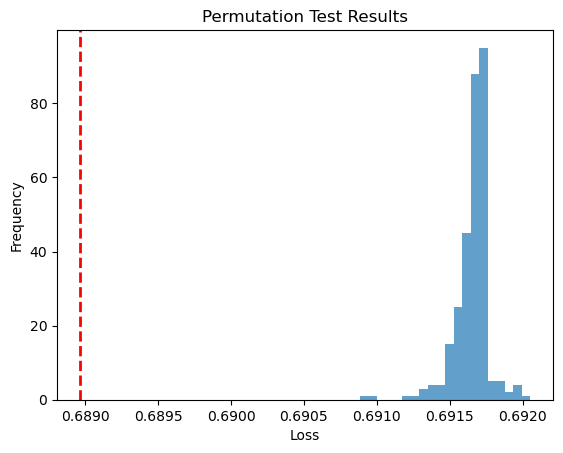

Observed Loss: 0.6890
P-Value: 0.0000


In [20]:
n_samples = len(x)
obs_loss = train_model(x_tensor, y_tensor)

# Permutation testing
n_permutations = 300
resampled_losses = []

for _ in range(n_permutations):
    permuted_y = y_tensor[torch.randperm(n_samples)]
    resampled_loss = train_model(x_tensor, permuted_y)
    resampled_losses.append(resampled_loss)

# Calculate p-value
p_value = sum([1 for loss in resampled_losses if loss <= obs_loss]) / n_permutations

# Plot distribution of permuted test statistics
plt.hist(resampled_losses, bins=20, alpha=0.7)
plt.axvline(obs_loss, color='red', linestyle='dashed', linewidth=2)
plt.title('Permutation Test Results')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

print(f"Observed Loss: {obs_loss:.4f}")
print(f"P-Value: {p_value:.4f}")

### Explaination

* The p-value gives the probability of observing a loss as extreme as the actual observed loss under the null hypothesis. As shown, p-value is significantly smaller than 0.05, which suggests rejecting the null hypothesis. Hence the histogram follows. Therefore, it indicates a significant difference between the energy levels of Rock and Pop songs.